# <span style="color:orange"> Exercise 10.1 </span>

## <span style="color:green"> Task </span>
By adapting your Genetic Algorithm code, developed during the Numerical Exercise 9, write a C++ code to solve the TSP with a Simulated Annealing (SA) algorithm. Apply your code to the optimization of a path among
- 30 cities randomly placed on a circumference
- 30 cities randomly placed inside a square

Show your results via:

- a picture of the length of the best path as a function of the iteration of your algorithm
- a picture of the best path

## <span style="color:green"> Solution </span>
In order to complete the given task, the code inherits most functionalities from the Ex9 Genetic Algorithm class and adds a Simulated Annealing algorithm. This package also contains a citygen.hpp file that generates the city positions according to a specific configuration, a genetic.hpp file that contains the class for the Genetic Algorithm, a main.cpp file where the simulation is defined and ran, and various files with useful objects (population,individual,etc..).<br>
The parameters that are initialized from a configuration file are:
- layout(str): city arrangement
- ncities(int): number of cities
- box(float): size of city layout
- metric(str): type of metric for calculating distances
- iterations(int): number of iterations for the genetic algorithm
- N(int): number of explored temperatures
- step(double): increment of beta at each temperature value

The main function executes the Genetic Algorithm using a Simulated Annealing algorithm, that initially proposed a path that connects all cities, according to the appropriate boundary conditions. The quest for the most optimal path consists of suggesting a change in the proposed path using the Mutation function and, using the Metropolis algorithm, the code decides to accept or reject the new proposed path. The transition probability is:
$$ \Large{P = e^{-\beta(F_{new} - F_{old})}} $$
After a certain number of iterations at a fixed value of $\beta$, the latter multiplies itself by a step given in the settings, so that the temperature increase is slow enough to explore numerous values in the earliest stages.

The program saves the results for each simulation in a dedicated SQL database that contains the parameters of the simulation, the path with lowest fitness value, the fitness value for each beta value and the city arrangement.<br>
The notebook below exhaustively explores the outcomes of the various dependancies of the fitness value of the best individual, such as the dependancy on the increment step of $\beta$, the number of iterations for each $\beta$ value, the metric and more.
For this purpose, various values of each parameter are explored and fed to the simulation. A temporary configuration file is created with the right values and given to the main script as an input paramenter for each iteration (see second cell).<br>
The two main sections are dedicated to a city arrangement on a circumference and on a square.<br><br>

## <span style="color:red; display: block; text-align: center"> Circle </span>

In [4]:
import numpy as np
import sqlite3
import sys, os
sys.path.append("10.1/")
import utility
import time
import logging
import subprocess
logging.disable(sys.maxsize)
import datetime
import inspect
from numba import jit
from matplotlib import pyplot as plt
LAYOUT = "circle"

In [ ]:
def chop_microseconds(delta):
    """
    Remove microseconds from datetime object
    """
    return delta - datetime.timedelta(microseconds=delta.microseconds)

def run():
    global LAYOUT
    ncities = 32
    metrics = ["L1","L2"]
    boxes = [1]
    ntemps = [1000,2000,5000]
    iters = [100,500,1000,2000,5000]
    beta_steps = [1.0001, 1.001, 1.01, 1.1]
    total = len(metrics)*len(boxes)*len(iters)*len(beta_steps)*len(ntemps)
    percentages = [int(i*total/100) for i in np.arange(0,110,10)]
    index=1

    utility.clear_previous_databases(LAYOUT)
    print("----> Running a total of {} simulations\n".format(total))
    time_start = time.time()
    subprocess.run(["make"])
    for ntemp in ntemps:
        for step in beta_steps:
            for _iter in iters:
                for box in boxes:
                    for metric in metrics:
                        if index in percentages:
                            print("Executing simulation ",index,"/",total)
                            time_temp = time.time()
                            elapsed = time_temp - time_start
                            date = str(chop_microseconds(datetime.timedelta(seconds=elapsed)))
                            print("Time elapsed {}  ({:.2f} seconds)\n".format(date,elapsed))
                        utility.create_temp_ini(LAYOUT,ncities,box,metric,_iter,ntemp,step,"results"+str(index))
                        p = subprocess.Popen("./main tempfile.ini",shell=True,stdout=subprocess.DEVNULL,stderr=subprocess.DEVNULL)
                        output, err = p.communicate(b"input data that is passed to subprocess' stdin")
                        rc = p.returncode
                        index+=1
    time_end = time.time()
    date = str(chop_microseconds(datetime.timedelta(seconds=time_end - time_start)))
    print("Total time elapsed: {}\n".format(date))
    
run()

Cities generated on a circle


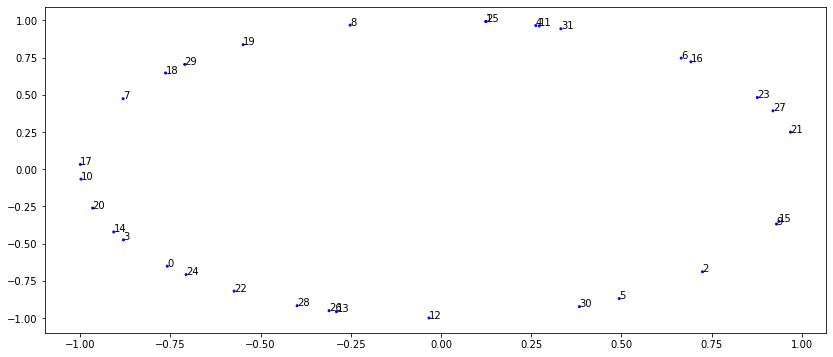

In [2]:
print(f"Cities generated on a {LAYOUT}")
cityi, cityx, cityy = np.loadtxt(f"./10.1/outputs/{LAYOUT}/cityposition.dat",unpack=True)
s = [4 for k in range(len(cityi))]
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))

### Dependancy on $\beta$ increment
This section aims to analyze the dependancy on beta of the fitness level of the best individual.

--> SETTINGS:	layout - circle,  ntemp - 5000,  iterations - 2000,  metric - L2
Found  4  queries


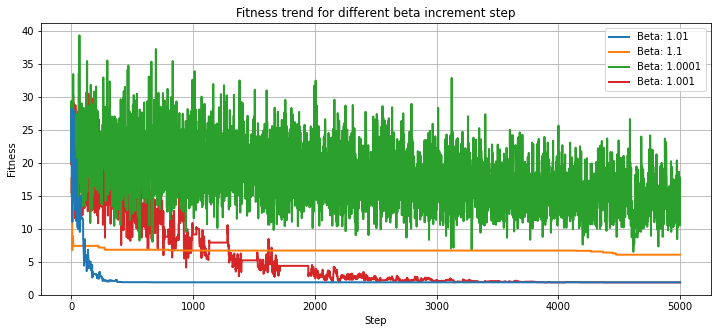

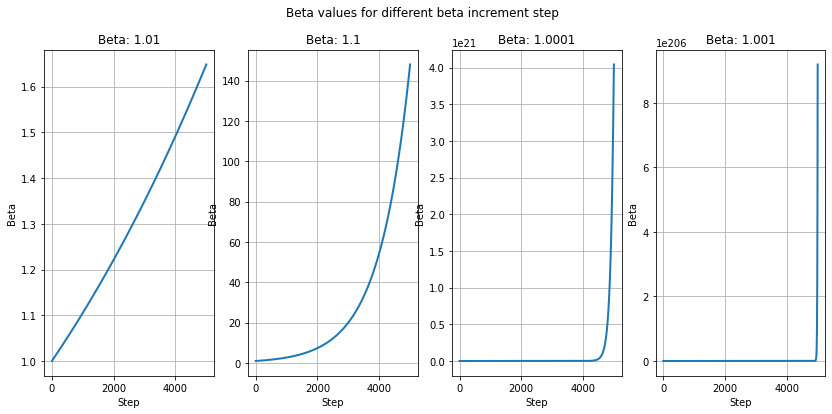

In [3]:
#explore beta values
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,iterations=2000,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = [q.get_fitness() for q in queries]
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i,res in enumerate(results):
    fitness = [j[-1] for j in res]
    plt.plot(fitness,linewidth=2,label="Beta: "+str(queries[i].get_data()["beta_step"]),zorder=10/(i+1))
    plt.title("Fitness trend for different beta increment step")
    plt.xlabel("Step")
    plt.ylabel("Fitness")
    plt.grid(True)
plt.legend()
plt.show()
print("\n")
betas = sorted([[j[1] for j in res] for res in results])
fig, ax = plt.subplots(1,len(betas),figsize=(14,6))
plt.suptitle("Beta values for different beta increment step")
for index, beta in enumerate(betas):
    ax[index-1].set_title("Beta: "+str(queries[index-1].get_data()["beta_step"]))
    ax[index-1].plot(betas[index-1],linewidth=2)
    ax[index-1].set_xlabel("Step")
    ax[index-1].set_ylabel("Beta")
    ax[index-1].grid(True)
plt.show()
print("")

### Dependancy on number of iterations
The number of iterations is the number of times a new path is searched for a fixed value of $\beta$. The expectation for this dependancy is a faster convergence of the fitness value, because more possible paths are discovered in a shorter amount of time, therefore finding the optimal path in an early iteration

--> SETTINGS:	layout - circle,  ntemp - 5000,  metric - L2,  beta_step - 1.01
Found  5  queries


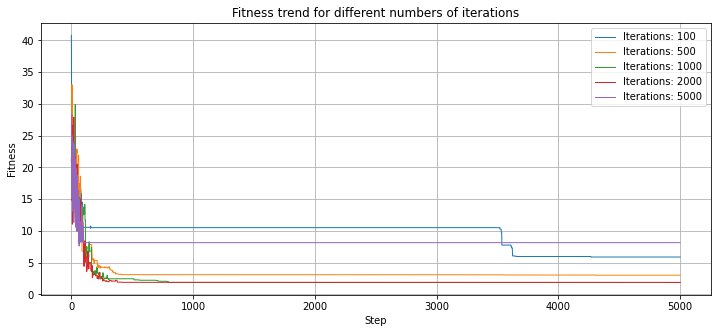

In [4]:
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,metric="L2",beta_step=1.01)
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = [q.get_fitness() for q in queries]
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i,res in enumerate(results):
    fitness = [j[-1] for j in res]
    plt.plot(fitness,linewidth=1,label="Iterations: "+str(queries[i].get_data()["iterations"]))
    plt.title("Fitness trend for different numbers of iterations")
    plt.xlabel("Step")
    plt.ylabel("Fitness")
    plt.grid(True)
plt.legend()
plt.show()
print("")

### Dependency on metric

--> SETTINGS:	layout - circle,  ntemp - 5000,  iterations - 5000,  beta_step - 1.01
Found  2  queries


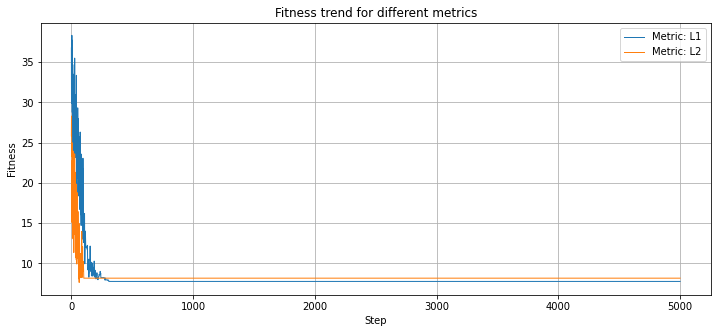

In [5]:
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,iterations=5000,beta_step=1.01)
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = [q.get_fitness() for q in queries]
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i,res in enumerate(results):
    fitness = [j[-1] for j in res]
    plt.plot(fitness,linewidth=1,label="Metric: "+str(queries[i].get_data()["metric"]))
    plt.title("Fitness trend for different metrics")
    plt.xlabel("Step")
    plt.ylabel("Fitness")
    plt.grid(True)
plt.legend()
plt.show()

## Best paths
In the current section a graph for the best path for a given configuration. The criteria of selection for the parameters is the following:
- Fixed beta step of 1.01, which has one of the best convergences as shown above
- Fixed metric L2
- Variation of ```number of explored temperatures``` and ```number of iterations per population```.
The values for both quantities is 1000 and 5000 for a total of 4 configuration, because the goal is to show that a good balance of those values is necessary for a good convergence (e.g. a very high iteration number and number of temperatures, $1^{st}$ path, overfits the optimal path.

--> SETTINGS:	layout - circle,  ntemp - 5000,  iterations - 5000,  beta_step - 1.01,  metric - L2
Found  1  queries


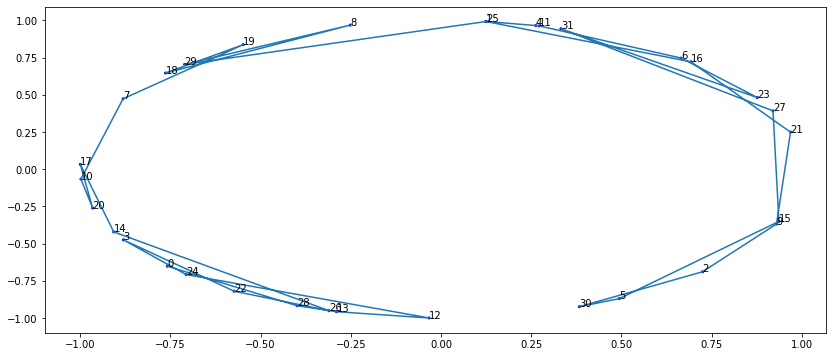

Fitness: 8.157117




In [6]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,iterations=5000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n".format(fitnessvalue))

--> SETTINGS:	layout - circle,  ntemp - 5000,  iterations - 1000,  beta_step - 1.01,  metric - L2
Found  1  queries


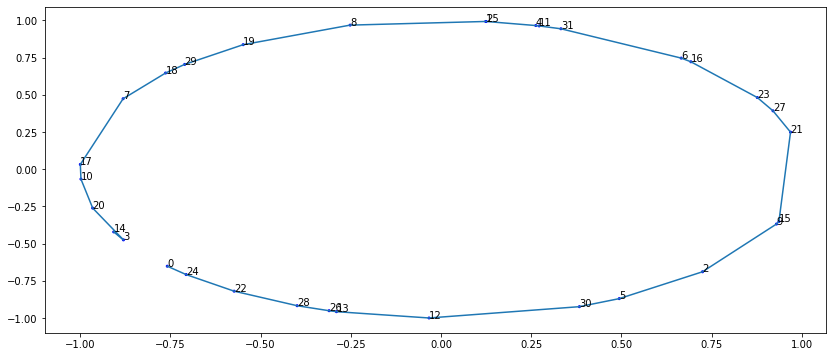

Fitness: 1.893024




In [7]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,iterations=1000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n".format(fitnessvalue))

--> SETTINGS:	layout - circle,  ntemp - 1000,  iterations - 5000,  beta_step - 1.01,  metric - L2
Found  1  queries


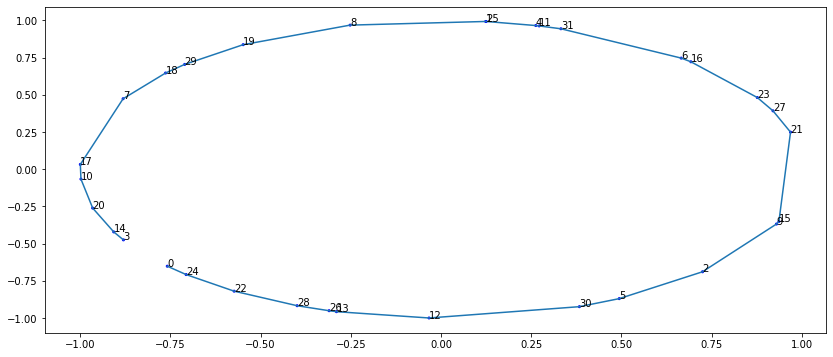

Fitness: 1.869176




In [8]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=1000,iterations=5000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n".format(fitnessvalue))

--> SETTINGS:	layout - circle,  ntemp - 1000,  iterations - 1000,  beta_step - 1.01,  metric - L2
Found  1  queries


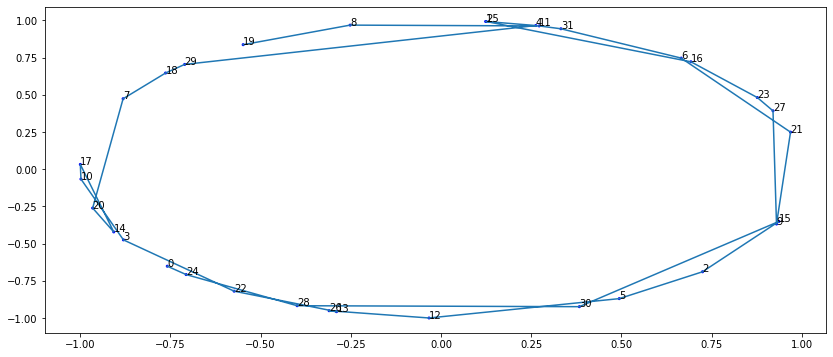

Fitness: 6.715479





In [9]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=1000,iterations=1000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n\n".format(fitnessvalue))

## <span style="color:red; display: block; text-align: center"> Square </span>

In [ ]:
run()

Cities generated on a square


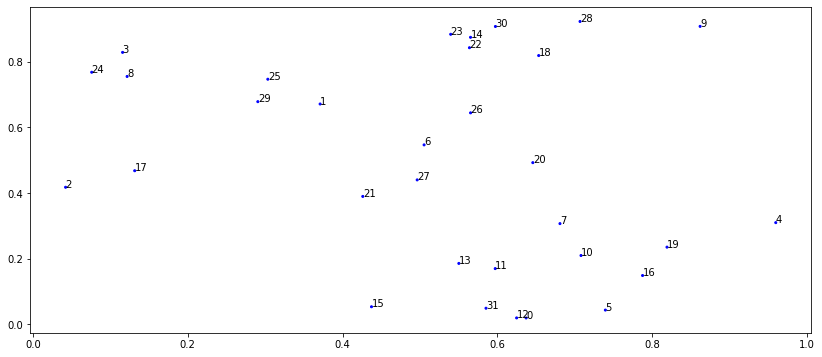

In [13]:
LAYOUT = "square"
print(f"Cities generated on a {LAYOUT}")
cityi, cityx, cityy = np.loadtxt(f"./10.1/outputs/{LAYOUT}/cityposition.dat",unpack=True)
s = [4 for k in range(len(cityi))]
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))

### Dependancy on $\beta$ increment
This section aims to analyze the dependancy on beta of the fitness level of the best individual.

--> SETTINGS:	layout - square,  ntemp - 5000,  iterations - 2000,  metric - L2
Found  4  queries


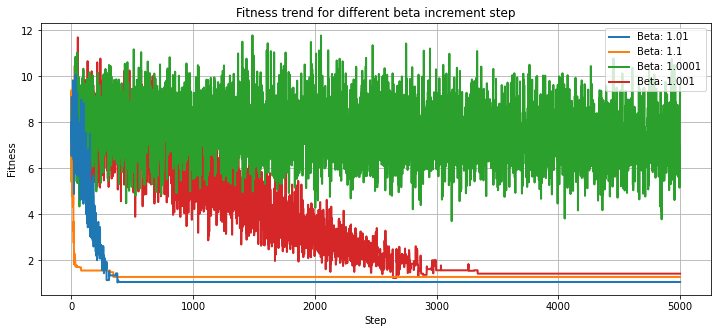

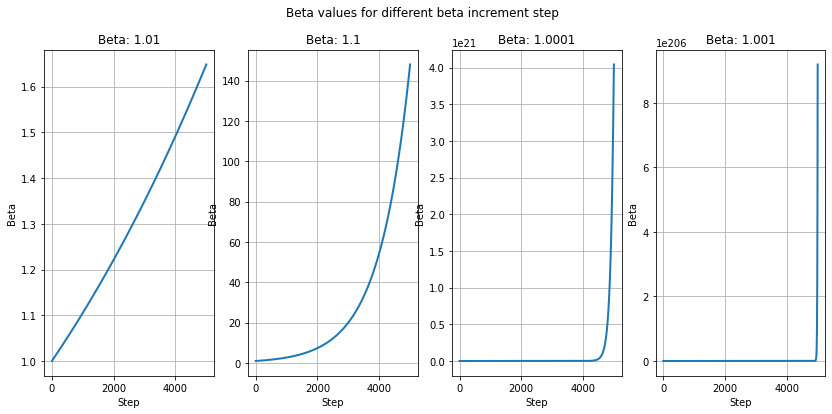

In [14]:
#explore beta values
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,iterations=2000,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = [q.get_fitness() for q in queries]
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i,res in enumerate(results):
    fitness = [j[-1] for j in res]
    plt.plot(fitness,linewidth=2,label="Beta: "+str(queries[i].get_data()["beta_step"]),zorder=10/(i+1))
    plt.title("Fitness trend for different beta increment step")
    plt.xlabel("Step")
    plt.ylabel("Fitness")
    plt.grid(True)
plt.legend()
plt.show()
print("\n")
betas = sorted([[j[1] for j in res] for res in results])
fig, ax = plt.subplots(1,len(betas),figsize=(14,6))
plt.suptitle("Beta values for different beta increment step")
for index, beta in enumerate(betas):
    ax[index-1].set_title("Beta: "+str(queries[index-1].get_data()["beta_step"]))
    ax[index-1].plot(betas[index-1],linewidth=2)
    ax[index-1].set_xlabel("Step")
    ax[index-1].set_ylabel("Beta")
    ax[index-1].grid(True)
plt.show()
print("")

### Dependancy on number of iterations
The number of iterations is the number of times a new path is searched for a fixed value of $\beta$. The expectation for this dependancy is a faster convergence of the fitness value, because more possible paths are discovered in a shorter amount of time, therefore finding the optimal path in an early iteration

--> SETTINGS:	layout - square,  ntemp - 5000,  metric - L2,  beta_step - 1.01
Found  5  queries


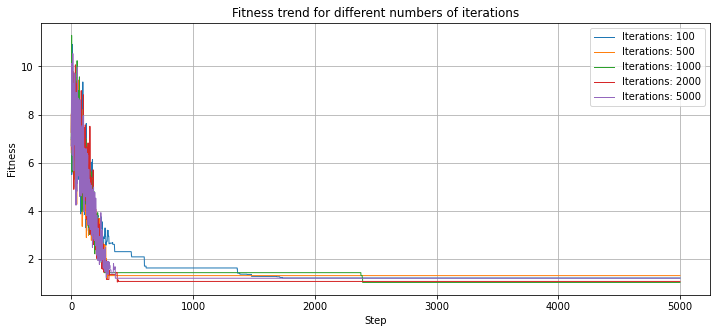

In [15]:
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,metric="L2",beta_step=1.01)
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = [q.get_fitness() for q in queries]
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i,res in enumerate(results):
    fitness = [j[-1] for j in res]
    plt.plot(fitness,linewidth=1,label="Iterations: "+str(queries[i].get_data()["iterations"]))
    plt.title("Fitness trend for different numbers of iterations")
    plt.xlabel("Step")
    plt.ylabel("Fitness")
    plt.grid(True)
plt.legend()
plt.show()
print("")

### Dependency on metric

--> SETTINGS:	layout - square,  ntemp - 5000,  iterations - 5000,  beta_step - 1.01
Found  2  queries


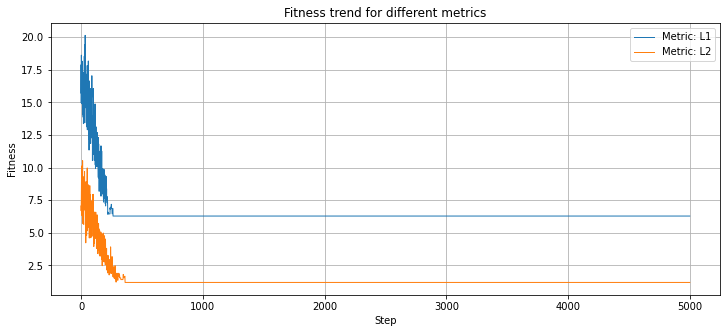

In [16]:
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,iterations=5000,beta_step=1.01)
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = [q.get_fitness() for q in queries]
fig, ax = plt.subplots(1,1,figsize=(12,5))
for i,res in enumerate(results):
    fitness = [j[-1] for j in res]
    plt.plot(fitness,linewidth=1,label="Metric: "+str(queries[i].get_data()["metric"]))
    plt.title("Fitness trend for different metrics")
    plt.xlabel("Step")
    plt.ylabel("Fitness")
    plt.grid(True)
plt.legend()
plt.show()

## Best paths
In the current section, as for the circular configuration, a graph for the best path for a given configuration. The criteria of selection for the parameters is still the following:
- Fixed beta step of 1.01, which has one of the best convergences as shown above
- Fixed metric L2
- Variation of ```number of explored temperatures``` and ```number of iterations per population```.
The values for both quantities is 1000 and 5000 for a total of 4 configuration, because the goal is to show that a good balance of those values is necessary for a good convergence (e.g. a very high iteration number and number of temperatures, $1^{st}$ path, overfits the optimal path.

--> SETTINGS:	layout - square,  ntemp - 5000,  iterations - 5000,  beta_step - 1.01,  metric - L2
Found  1  queries


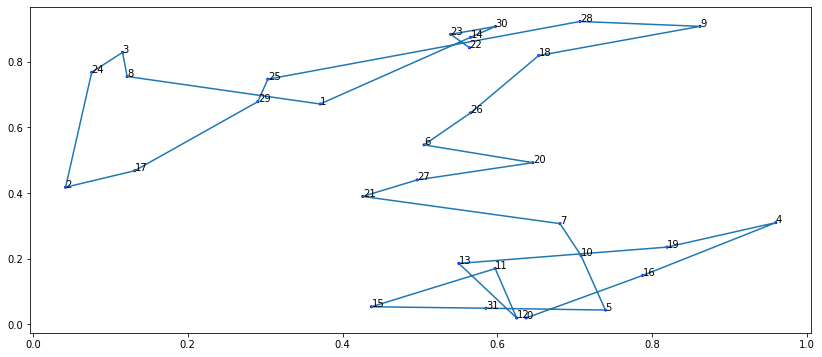

Fitness: 1.197687




In [17]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,iterations=5000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n".format(fitnessvalue))

--> SETTINGS:	layout - square,  ntemp - 5000,  iterations - 1000,  beta_step - 1.01,  metric - L2
Found  1  queries


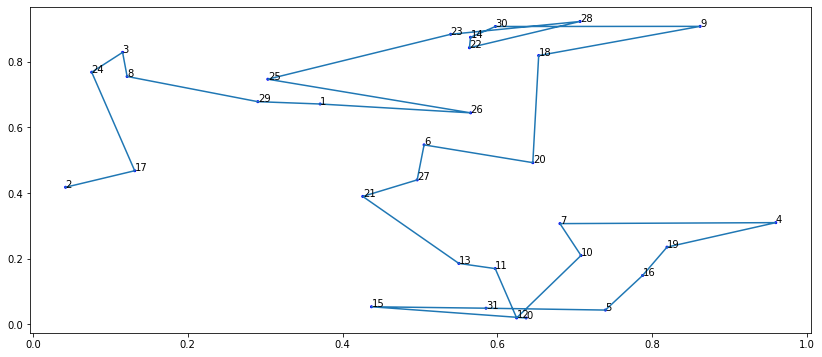

Fitness: 1.023123




In [18]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=5000,iterations=1000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n".format(fitnessvalue))

--> SETTINGS:	layout - square,  ntemp - 1000,  iterations - 5000,  beta_step - 1.01,  metric - L2
Found  1  queries


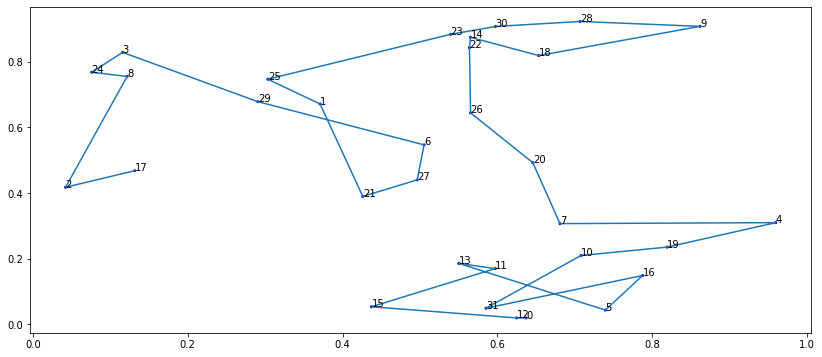

Fitness: 1.003278




In [19]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=1000,iterations=5000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n".format(fitnessvalue))

--> SETTINGS:	layout - square,  ntemp - 1000,  iterations - 5000,  beta_step - 1.01,  metric - L2
Found  1  queries


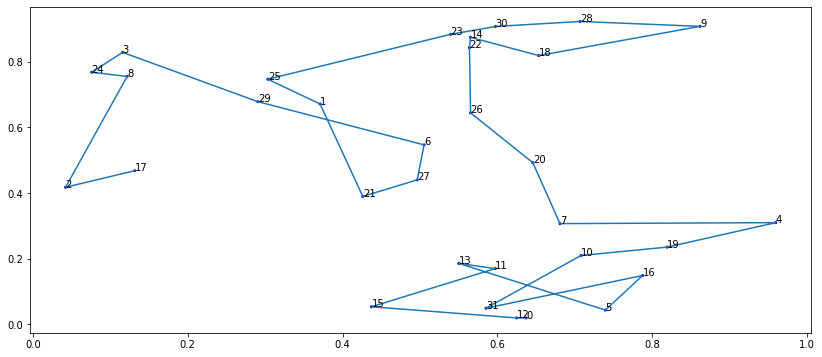

Fitness: 1.003278




In [20]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=1000,iterations=5000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n".format(fitnessvalue))

--> SETTINGS:	layout - square,  ntemp - 1000,  iterations - 5000,  beta_step - 1.01,  metric - L2
Found  1  queries


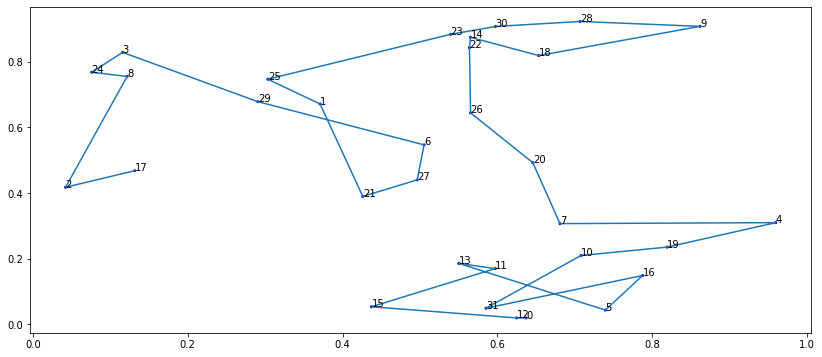

Fitness: 1.003278




In [21]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(cityx, cityy,color="blue",s=s)
for index, txt in enumerate(cityi):
    ax.annotate(int(txt), (cityx[index], cityy[index]))
reader = utility.DatabaseHandler(layout=LAYOUT,ntemp=1000,iterations=5000,beta_step=1.01,metric="L2")
print(reader)
queries = reader.search(False)
print("Found ",len(queries)," queries")
results = queries[0].get_best()
fitnessvalue = queries[0].get_fitness()[-1][2]
plt.plot([cityx[gene] for gene in results],[cityy[gene] for gene in results])
plt.show()
print("Fitness: {}\n\n".format(fitnessvalue))

## <span style="color:green"> Results </span>
The fitness value of the best individual found has been explored by tweaking numerous parameters. According to both city arrangements, the better convergence is obtained for a value of $\beta = 0.01$, while a faster convergence is obtained for a value of $\beta = 1.1$. The latter is considered to be too large because quickly converges to a value that is above the best possible one.<br>
Both graphs regarding the different numbers of iterations demostrate that the value ought not to be too small nor too large. In In the first case it is possible that an optimal solution for a given value of $\beta$ cannot be found due to the small amount of iterations, while in the second case a non-optimal solution may be found too early. In the graphs showing the best paths, it is also possible to see that the best fitness values are achieved for mixed values of temperatures and iterations (1000 and 5000 or viceversa), meaning that balanced values should be seeked for these parameters.


# <span style="color:orange"> Exercise 10.2 </span>
## <span style="color:green"> Task </span>
Parallelize the Simulated Annealing algorithm with MPI

## <span style="color:green"> Solution </span>

In [29]:
import sys, os
sys.path.append("./10.2/")
import utils
from matplotlib import pyplot as plt

basedir = "./10.2/outputs/"
ncities = 32
iters = 2000
ntemps = 1000
box = 1
betastep = 1.004

processes = 5

2    [(2.005468,), (1.951597,)]
3    [(7.842071,), (1.9144,), (5.13359,)]
4    [(7.191554,), (6.953634,), (1.932927,), (7.17285,)]
5    [(4.060198,), (6.145537,), (4.060198,), (2.005465,), (1.874553,)]


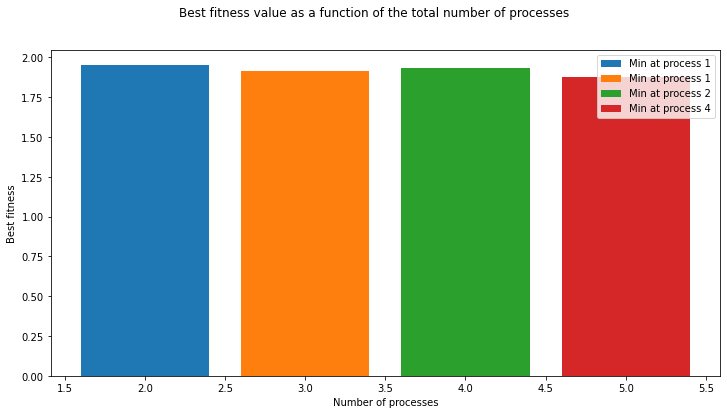

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
plt.suptitle("Best fitness value as a function of the total number of processes")
mins = list()
indexes = {
    "1" : 0,
    "2" : 0,
    "3" : 0,
    "4" : 0
}
indexes = {str(k):0 for (k,v) in zip([i for i in range(processes)],[i for i in range(processes)])}
for p in range(2,processes+1):
    reader = utils.DatabaseHandler(processes=p, layout="circle")
    queries = reader.search(False)
    results = queries[0].get_result("FITNESS")
    print(p,"  ",results)
    at = results.index(min(results))
    indexes[str(at)]+=1
    plt.bar(p,min(results),label=f"Min at process {at}")
    plt.xlabel("Number of processes")
    plt.ylabel("Best fitness")
    mins.append(min(results))
        
plt.legend()
plt.show()

2    [(14992.0,), (14992.0,)]
3    [(11198.0,), (11198.0,), (11198.0,)]
4    [(12492.0,), (12491.0,), (12492.0,), (12492.0,)]
5    [(11276.0,), (11278.0,), (11276.0,), (11276.0,), (11275.0,)]


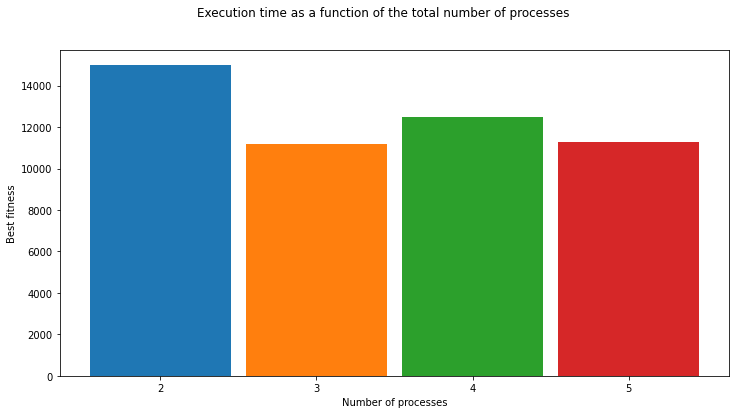

In [45]:
fig, ax = plt.subplots(figsize=(12,6))
plt.suptitle("Execution time as a function of the total number of processes")
mins = list()
for p in range(2,processes+1):
    reader = utils.DatabaseHandler(processes=p, layout="circle")
    queries = reader.search(False)
    results = queries[0].get_result("TIME")
    print(p,"  ",results)
    at = results.index(min(results))
    plt.bar(p,min(results), width=0.9)
    plt.xticks([i for i in range(2,processes+1)])
    plt.xlabel("Number of processes")
    plt.ylabel("Best fitness")
    mins.append(min(results))
plt.show()

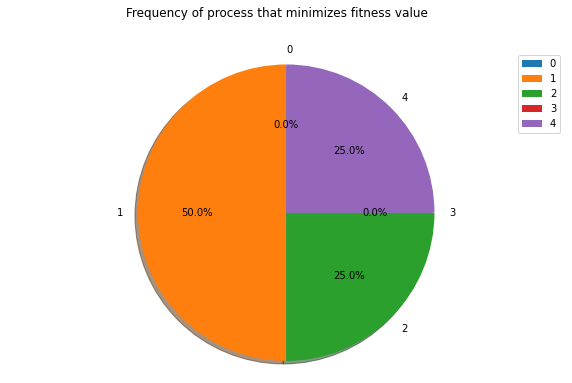

In [37]:
sizes = list(indexes.values())
labels = indexes.keys()
fig1, ax1 = plt.subplots(figsize=(10,6))
plt.suptitle("Frequency of process that minimizes fitness value")
explode = [0.0 for i in range(processes)]
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.show()